In [43]:
# Importing necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt


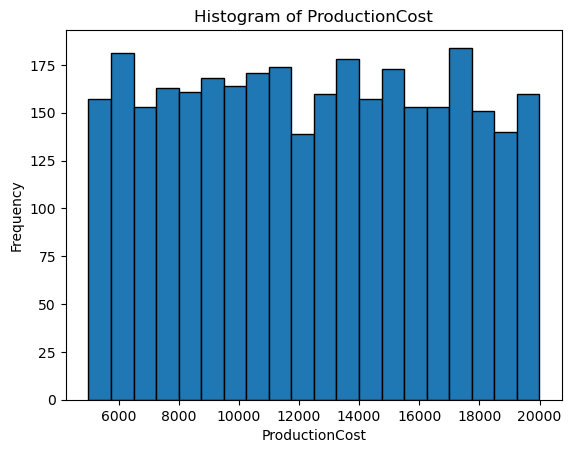

ProductionCost          1.000000
ProductionVolume        0.029584
DefectStatus            0.026720
InventoryTurnover       0.022749
DeliveryDelay           0.017365
DefectRate              0.014428
AdditiveProcessTime     0.011075
MaintenanceHours        0.007333
StockoutRate            0.006006
WorkerProductivity      0.005030
QualityScore           -0.001603
AdditiveMaterialCost   -0.002114
EnergyEfficiency       -0.002778
DowntimePercentage     -0.004078
EnergyConsumption      -0.006728
SafetyIncidents        -0.006958
SupplierQuality        -0.024103
Name: ProductionCost, dtype: float64


In [44]:
# Step 1: Data Preprocessing
# Load the dataset
data = pd.read_csv("../datasets/manufacturing_defect_dataset.csv")

# Handle missing values if any
data.fillna(0, inplace=True)

# Check for data imbalance
plt.hist(data['ProductionCost'], bins=20, edgecolor='black')
plt.title('Histogram of ProductionCost')
plt.xlabel('ProductionCost')
plt.ylabel('Frequency')
plt.show()

# Analyse correlations with ProductionCost
corr_matrix = data.corr()
target_corr = corr_matrix['ProductionCost'].drop('ProductionCost')  # Exclude the target itself
print(corr_matrix['ProductionCost'].sort_values(ascending=False))



In [45]:
# Step 2: Feature Selection
# Drop features with low correlation (example: absolute value < 0.1)
low_corr_features = target_corr[abs(target_corr) < 0.01].index
print("Features to drop due to low correlation:", low_corr_features)

X = data.drop(['ProductionCost'] + list(low_corr_features), axis=1)
y = data['ProductionCost']

# Use mutual information for feature selection
best_features = SelectKBest(score_func=mutual_info_regression, k=5)
X_best = best_features.fit_transform(X, y)


Features to drop due to low correlation: Index(['QualityScore', 'MaintenanceHours', 'DowntimePercentage',
       'StockoutRate', 'WorkerProductivity', 'SafetyIncidents',
       'EnergyConsumption', 'EnergyEfficiency', 'AdditiveMaterialCost'],
      dtype='object')


In [46]:
# Step 3: Model Selection
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_best, y, test_size=0.2, random_state=42)


In [47]:
# Step 4: Model Evaluation
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Handling imbalanced data
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

# Initialize and train the Random Forest Classifier
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)


RandomForestRegressor(random_state=42)

Mean Absolute Error: 3577.688712925955
Mean Squared Error: 18344968.468605917
Root Mean Squared Error: 4283.102668464289
R^2 Score: -0.07082286735343168


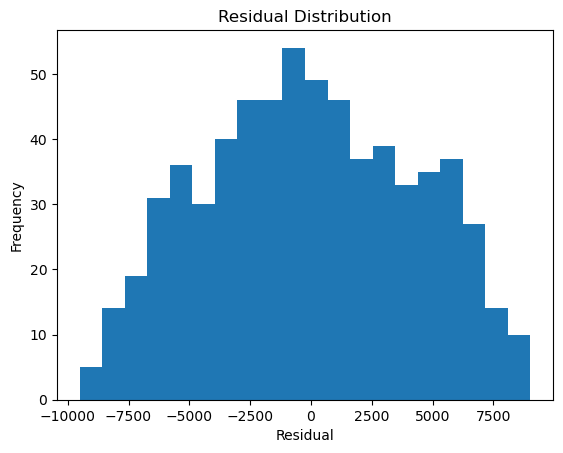

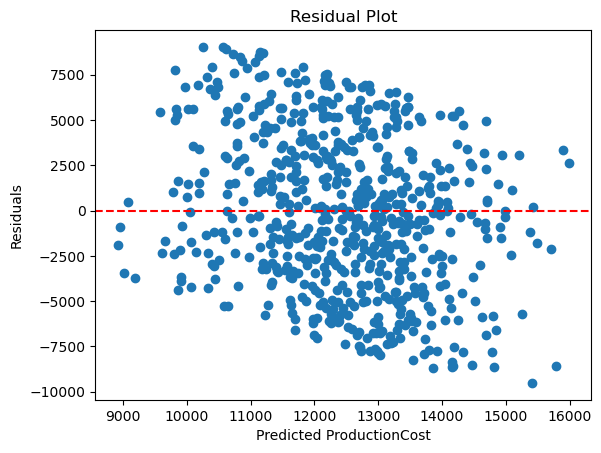

In [48]:
# Step 5: Model Evaluation
# Predictions
y_pred = rf_regressor.predict(X_test_scaled)

# Calculate performance metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = mse ** 0.5
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R^2 Score: {r2}")

# Residuals histogram
residuals = y_test - y_pred
plt.hist(residuals, bins=20)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Residuals scatterplot
plt.scatter(y_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted ProductionCost')
plt.ylabel('Residuals')
plt.show()


Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 150}
Mean Absolute Error: 3542.0169608244173
Mean Squared Error: 17486348.715740602
Root Mean Squared Error: 4181.668173796266
R^2 Score: -0.020703965960771065


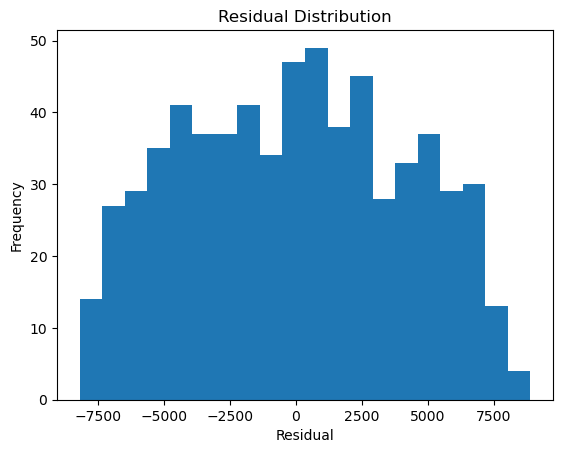

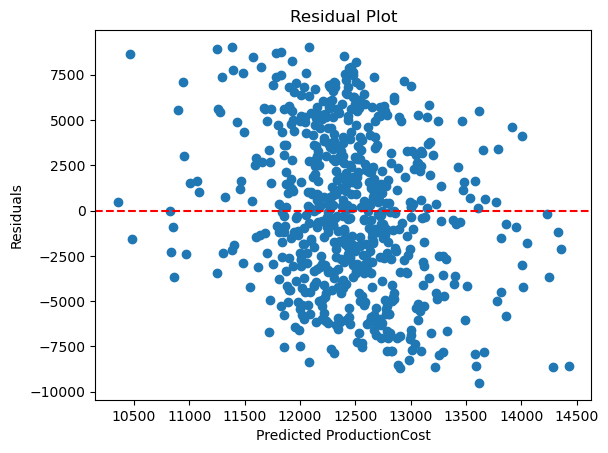

In [49]:
# Step 6: Model Optimization
# Define hyperparameters grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the grid search
grid_search = GridSearchCV(estimator=rf_regressor, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# Perform grid search to find the best hyperparameters
grid_search.fit(X_train_scaled, y_train)

# Best parameters
print("Best Parameters:", grid_search.best_params_)

# Reinitialize the classifier with best parameters
best_rf_classifier = grid_search.best_estimator_

# Evaluate the model with best parameters
y_pred_best = best_rf_classifier.predict(X_test_scaled)

# Calculate performance metrics
best_mae = mean_absolute_error(y_test, y_pred_best)
best_mse = mean_squared_error(y_test, y_pred_best)
best_rmse = best_mse ** 0.5
best_r2 = r2_score(y_test, y_pred_best)

print(f"Mean Absolute Error: {best_mae}")
print(f"Mean Squared Error: {best_mse}")
print(f"Root Mean Squared Error: {best_rmse}")
print(f"R^2 Score: {best_r2}")

# Residuals histogram
best_residuals = y_test - y_pred_best
plt.hist(best_residuals, bins=20)
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.show()

# Residuals scatterplot
plt.scatter(y_pred_best, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted ProductionCost')
plt.ylabel('Residuals')
plt.show()


In [50]:
# # Compare alternative models

# from sklearn.preprocessing import StandardScaler, OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import train_test_split

# # Preprocess features: Combine numerical and categorical preprocessing
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', StandardScaler(), numerical_features),
#         ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
#     ]
# )

# # Apply preprocessing
# X_processed = preprocessor.fit_transform(X)

# # Train-test split
# X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)


In [51]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error, r2_score

# # Train a Random Forest Regressor
# rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
# rf_model.fit(X_train, y_train)

# # Evaluate the model
# y_pred_rf = rf_model.predict(X_test)
# mae_rf = mean_absolute_error(y_test, y_pred_rf)
# r2_rf = r2_score(y_test, y_pred_rf)

# print(f"Random Forest - Mean Absolute Error: {mae_rf}")
# print(f"Random Forest - R^2 Score: {r2_rf}")


In [52]:
# from xgboost import XGBRegressor

# # Train an XGBoost Regressor
# xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
# xgb_model.fit(X_train, y_train)

# # Evaluate the model
# y_pred_xgb = xgb_model.predict(X_test)
# mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
# r2_xgb = r2_score(y_test, y_pred_xgb)

# print(f"XGBoost - Mean Absolute Error: {mae_xgb}")
# print(f"XGBoost - R^2 Score: {r2_xgb}")


In [53]:
# from lightgbm import LGBMRegressor

# # Train a LightGBM Regressor
# lgb_model = LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
# lgb_model.fit(X_train, y_train)

# # Evaluate the model
# y_pred_lgb = lgb_model.predict(X_test)
# mae_lgb = mean_absolute_error(y_test, y_pred_lgb)
# r2_lgb = r2_score(y_test, y_pred_lgb)

# print(f"LightGBM - Mean Absolute Error: {mae_lgb}")
# print(f"LightGBM - R^2 Score: {r2_lgb}")


In [54]:
# from sklearn.linear_model import Ridge

# # Train a Ridge Regressor
# ridge_model = Ridge(alpha=1.0)  # Regularization strength
# ridge_model.fit(X_train, y_train)

# # Evaluate the model
# y_pred_ridge = ridge_model.predict(X_test)
# mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
# r2_ridge = r2_score(y_test, y_pred_ridge)

# print(f"Ridge Regression - Mean Absolute Error: {mae_ridge}")
# print(f"Ridge Regression - R^2 Score: {r2_ridge}")


In [55]:
# from sklearn.linear_model import Lasso

# # Train a Lasso Regressor
# lasso_model = Lasso(alpha=0.1)  # Regularization strength
# lasso_model.fit(X_train, y_train)

# # Evaluate the model
# y_pred_lasso = lasso_model.predict(X_test)
# mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
# r2_lasso = r2_score(y_test, y_pred_lasso)

# print(f"Lasso Regression - Mean Absolute Error: {mae_lasso}")
# print(f"Lasso Regression - R^2 Score: {r2_lasso}")


In [56]:
# print(f"Random Forest - Mean Absolute Error: {mae_rf}, R^2 Score: {r2_rf}")
# print(f"XGBoost - Mean Absolute Error: {mae_xgb}, R^2 Score: {r2_xgb}")
# print(f"LightGBM - Mean Absolute Error: {mae_lgb}, R^2 Score: {r2_lgb}")
# print(f"Ridge Regression - Mean Absolute Error: {mae_ridge}, R^2 Score: {r2_ridge}")
# print(f"Lasso Regression - Mean Absolute Error: {mae_lasso}, R^2 Score: {r2_lasso}")

# print(f"CNN - Mean Absolute Error: {mae}, R^2 Score: {r2}")
